In this notebook, I use the PyProximal example code on proximal algorithms for deblurring to understand how hyperparameters affect image denoising and deblurring. I also compare the performance of ISTA and FISTA to other proximal algorithms

# Introduction

In my last notebook, I ran ISTA on toy examples. In this notebook, I want to measure its performance on images, so that I can later compare it to the unrolled ISTA version. In order to do this, I adapted code from a tutorial from  the Pyproximal package. Unfortunately, I can no longer find the tutorial on the Pyproximal docs, but a similar tutorial can be found [here](https://pyproximal.readthedocs.io/en/stable/tutorials/denoising.html?highlight=misc.ascent).

In this code, the deblurring performance of FISTA, normal least squares optimization and TV (total variation). Total variation is a popular image denoising technique that minimizes the total variation in an image.

FISTA is the *fast* ISTA algorithm, it is a variation of ISTA that is used in practice instead of ISTA due to its speed. Compared to ISTA, FISTA is the same except for an additional term which serves to push the approximation in the right direction.

At the beginning of the FISTA algorithm, you initial two additional parameters, $\mu$ and $y( \mu)$. At every iteration you calculate ISTA like normal, and then before you move onto the next iteration, you take that ISTA result, lets called it $z_{t+1}$, and calculate $(1-y) z_{t+1} + y z_t$.

Now, instead of using $z_{t+1}$ in your next iteration, you use the output of this equation instead.

The additional term $y$ is called a momentum term and it's used to regulate the step size. Like real momentum, it allows you to take larger step sizes towards your desired direction.


# Imports


In [ ]:
!pip install pylops pyproximal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc

import pyproximal
import pylops

# import libraries

import matplotlib.image as mpimg
import os
import cv2

# %tensorflow_version 2.x

import PIL

from skimage.metrics import peak_signal_noise_ratio

We will be using an example image from the SciPy Misc preloaded dataset.

In [ ]:
# Load image
im = misc.ascent()
# im = img / np.max(img)
Nz, Nx = im.shape


<ipython-input-3-90016585397d>:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  im = misc.ascent()


# Preprocessing data

We will define a Gaussian blurring kernel to apply on the image

Image shape (512, 512)


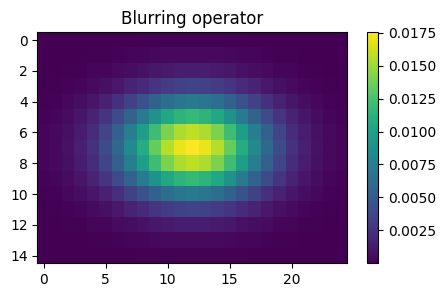

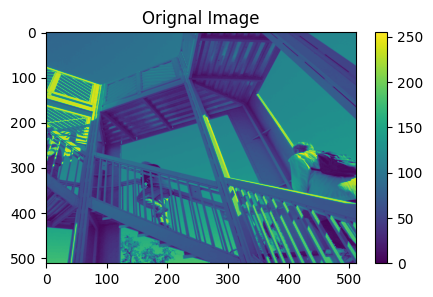

In [ ]:
# Code from PyProximal tutorial
# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.03 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(im)
ax.set_title("Orignal Image")
fig.colorbar(him, ax=ax)
ax.axis("tight")

print(f"Image shape {im.shape}")

Cop = pylops.signalprocessing.Convolve2D(
    (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)

We'll create three images to test: the image with only added noise, the image with a blurring kernel and added noise applied, and the image with just the blurring kernel.

Let's define the noise we're adding. It is defined as vector from a normal Gaussian distribution, multiplied by $\sigma=50$. I decided on this sigma value through trial and error, based on how the resulting image looks.

In [ ]:
sigman = 50
n = sigman  * np.random.normal(0, 1, im.shape)

In [ ]:
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.03 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h2 = hz[:, np.newaxis] * hx[np.newaxis, :]

Now we'll create the images

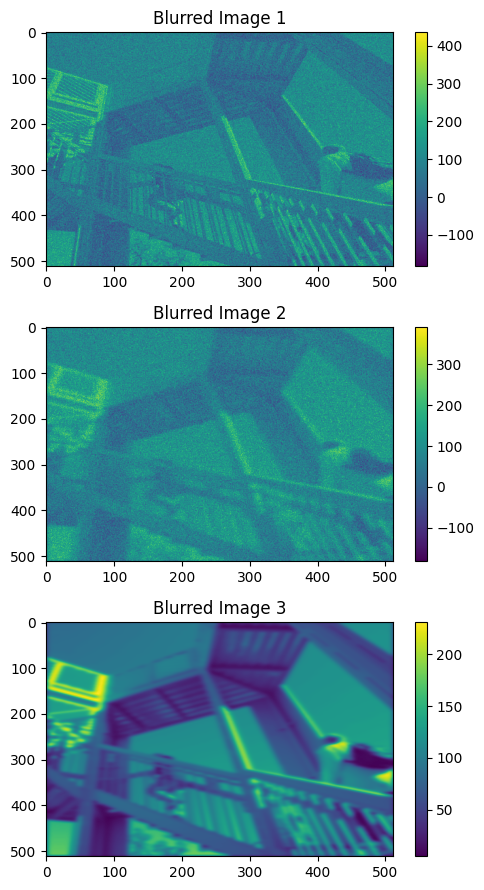

In [ ]:
# image 1: noise only

# we make a fake kernel because the pyproximal algorithms
# require one as input
A = np.eye(Nz*Nx)
Aop = pylops.MatrixMult(A)
Aop.explicit = False

im1 = im + n


# image 2 : noise and blur
im2 = (Cop*im) + n


# image 3: blur only
im3 = Cop*im

# plot images

fig, axes = plt.subplots(3, 1, figsize=(5, 9))  # Create a subplot grid with 3 rows and 1 column

# Plot the first image
him1 = axes[0].imshow(im1.reshape(im.shape))
axes[0].set_title("Blurred Image 1")
fig.colorbar(him1, ax=axes[0])
axes[0].axis("tight")

# Plot the second image
him2 = axes[1].imshow(im2)
axes[1].set_title("Blurred Image 2")
fig.colorbar(him2, ax=axes[1])
axes[1].axis("tight")

# Plot the third image
him3 = axes[2].imshow(im3)
axes[2].set_title("Blurred Image 3")
fig.colorbar(him3, ax=axes[2])
axes[2].axis("tight")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

# Run Pyproximal algorithms

We'll define and run the pyproximal algorithms, as given in their example script. We'll run and evaluate them on all three images. In order to evaluate them, we will be using the Pyproximal scripts to plot the images. We will also be measuring PSNR for each process.

## Image 1: Noise Only

In [ ]:
eps = 1e-2
maxit = 100


# # ISTA
# x_ista, niteri, costi = \
#     pylops.optimization.sparsity.ista(Aop, im1.ravel(), niter=maxit, eps=eps, tol=1e-10,
                                      # show=False)

# FISTA
x_fista, niterf, costf = \
    pylops.optimization.sparsity.fista(Aop, im1.ravel(), niter=maxit, eps=eps,
                                       tol=1e-10, show=False)

# TWIST (Note that since the smallest eigenvalue is zero, we arbitrarily
# choose a small value for the solver to converge stably)
l1 = pyproximal.proximal.L1(sigma=eps)
eigs = (Aop.H * Aop).eigs()
eigs = (np.abs(eigs[0]), 5e-1)
x_twist, costt = \
    pyproximal.optimization.primal.TwIST(l1, Aop, im1.ravel(), eigs=eigs,
                                         x0=np.zeros(Nz), niter=maxit,
                                         show=False, returncost=True)

# x_ista = x_ista.reshape(im.shape)
x_fista = x_fista.reshape(im.shape)
x_twist = x_twist.reshape(im.shape)


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(im, cmap='gray', vmin=0, vmax=250)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(im1, cmap='gray', vmin=0, vmax=250)
axs[1].set_title(f'Noisy \n PSNR: {peak_signal_noise_ratio(im, im1)}')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imdeblur, cmap='gray', vmin=0, vmax=250)
axs[2].set_title(f'LS \n PSNR: {peak_signal_noise_ratio(im, imdeblur)}')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(imdeblurfista, cmap='gray', vmin=0, vmax=250)
axs[3].set_title(f'FISTA \n PSNR: {peak_signal_noise_ratio(im, imdeblurfista)}')
axs[3].axis('off')
axs[3].axis('tight')
axs[4].imshow(imdeblurtv, cmap='gray', vmin=0, vmax=250)
axs[4].set_title(f'TV \n PSNR: {peak_signal_noise_ratio(im, imdeblurtv)}')
axs[4].axis('off')
axs[4].axis('tight')


Even though I was able to get this code to run in a notebook earlier on, I am no longer able to reproduce the results. Now, the ISTA and FISTA algorithms run so long that that they kill the kernel. At this time, I am not able to debug why that is the case.

## Image 2: Noise and Blurring

In [ ]:
# Least squares
imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
    Cop, im2.ravel(), None, maxiter=50  # solvers need 1D arrays
)[0]
imdeblur = imdeblur.reshape(Cop.dims)

# FISTA
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)
Dop = [
    pylops.FirstDerivative((Nz, Nx), axis=0, edge=False),
    pylops.FirstDerivative((Nz, Nx), axis=1, edge=False),
]
DWop = Dop + [Wop]

imdeblurfista = pylops.optimization.sparsity.fista(
    Cop * Wop.H, im2.ravel(), eps=1e-1, niter=100
)[0]
imdeblurfista = imdeblurfista.reshape((Cop * Wop.H).dims)
imdeblurfista = Wop.H * imdeblurfista

# TV
imdeblurtv = pylops.optimization.sparsity.splitbregman(
    Cop,
    im2.ravel(),
    Dop,
    niter_outer=10,
    niter_inner=5,
    mu=1.5,
    epsRL1s=[2e0, 2e0],
    tol=1e-4,
    tau=1.0,
    show=False,
    **dict(iter_lim=5, damp=1e-4)
)[0]
imdeblurtv = imdeblurtv.reshape(Cop.dims)



(-0.5, 511.5, 511.5, -0.5)

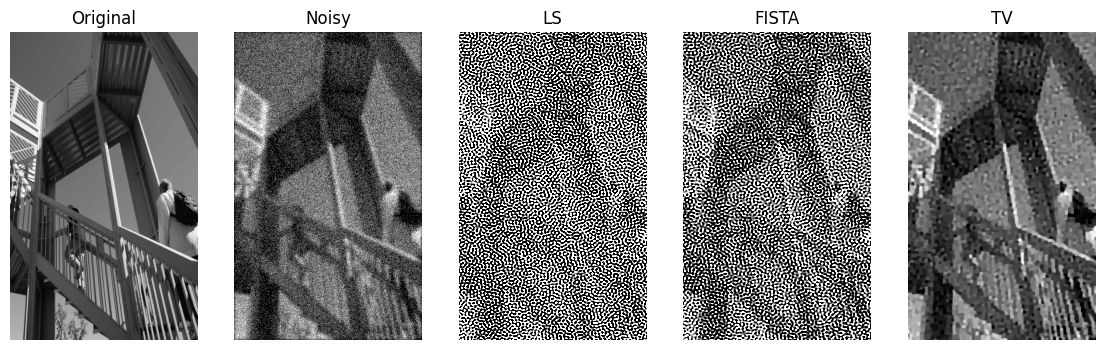

In [ ]:


fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(im, cmap='gray', vmin=0, vmax=250)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(im2, cmap='gray', vmin=0, vmax=250)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imdeblur, cmap='gray', vmin=0, vmax=250)
axs[2].set_title('LS')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(imdeblurfista, cmap='gray', vmin=0, vmax=250)
axs[3].set_title('FISTA')
axs[3].axis('off')
axs[3].axis('tight')
axs[4].imshow(imdeblurtv, cmap='gray', vmin=0, vmax=250)
axs[4].set_title('TV')
axs[4].axis('off')
axs[4].axis('tight')


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(im, cmap='gray', vmin=0, vmax=250)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(im2, cmap='gray', vmin=0, vmax=250)
axs[1].set_title(f'Noisy \n PSNR: {peak_signal_noise_ratio(im, im1)}')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imdeblur, cmap='gray', vmin=0, vmax=250)
axs[2].set_title(f'LS \n PSNR: {peak_signal_noise_ratio(im, imdeblur)}')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(imdeblurfista, cmap='gray', vmin=0, vmax=250)
axs[3].set_title(f'FISTA \n PSNR: {peak_signal_noise_ratio(im, imdeblurfista)}')
axs[3].axis('off')
axs[3].axis('tight')
axs[4].imshow(imdeblurtv, cmap='gray', vmin=0, vmax=250)
axs[4].set_title(f'TV \n PSNR: {peak_signal_noise_ratio(im, imdeblurtv)}')
axs[4].axis('off')
axs[4].axis('tight')


We see that LS and FISTA were not able to handle the added noise. I'm not sure why this happens but I assume it is because both these equations are based on the L2 norm $A^{T}(Ax - y)$, which doesn't account for the fact that $y = Ax + \text{added noise}$.

In my next notebook where I run unrolled ISTA, I will compare to see if that algorithm can handle this type of input.

## Image 3: Blurring Only

In [ ]:
# Least squares
imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
    Cop, im3.ravel(), None, maxiter=50  # solvers need 1D arrays
)[0]
imdeblur = imdeblur.reshape(Cop.dims)

# FISTA
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)
Dop = [
    pylops.FirstDerivative((Nz, Nx), axis=0, edge=False),
    pylops.FirstDerivative((Nz, Nx), axis=1, edge=False),
]
DWop = Dop + [Wop]

imdeblurfista = pylops.optimization.sparsity.fista(
    Cop * Wop.H, im3.ravel(), eps=1e-1, niter=100
)[0]
imdeblurfista = imdeblurfista.reshape((Cop * Wop.H).dims)
imdeblurfista = Wop.H * imdeblurfista

# TV
imdeblurtv = pylops.optimization.sparsity.splitbregman(
    Cop,
    im3.ravel(),
    Dop,
    niter_outer=10,
    niter_inner=5,
    mu=1.5,
    epsRL1s=[2e0, 2e0],
    tol=1e-4,
    tau=1.0,
    show=False,
    **dict(iter_lim=5, damp=1e-4)
)[0]
imdeblurtv = imdeblurtv.reshape(Cop.dims)



<ipython-input-16-0c531fe2ab9b>:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axs[1].set_title(f'Noisy \n PSNR: {peak_signal_noise_ratio(im, im1):.3f}')
<ipython-input-16-0c531fe2ab9b>:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axs[2].set_title(f'LS \n PSNR: {peak_signal_noise_ratio(im, imdeblur):.3f}')
<ipython-input-16-0c531fe2ab9b>:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axs[3].set_title(f'FISTA \n PSNR: {peak_signal_noise_ratio(im, imdeblurfista):.3f}')
<ipython-input-16-0c531fe2ab9b>:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axs[4].set_title(f'TV \n PSNR: {peak_signal_noise_ratio(im, imdeblurtv):.3f}')


(-0.5, 511.5, 511.5, -0.5)

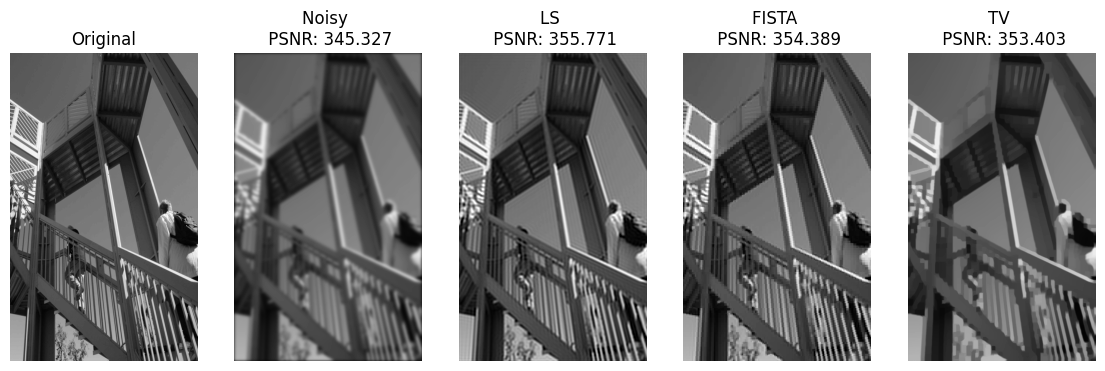

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(im, cmap='gray', vmin=0, vmax=250)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(im3, cmap='gray', vmin=0, vmax=250)
axs[1].set_title(f'Noisy \n PSNR: {peak_signal_noise_ratio(im, im1):.3f}')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imdeblur, cmap='gray', vmin=0, vmax=250)
axs[2].set_title(f'LS \n PSNR: {peak_signal_noise_ratio(im, imdeblur):.3f}')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(imdeblurfista, cmap='gray', vmin=0, vmax=250)
axs[3].set_title(f'FISTA \n PSNR: {peak_signal_noise_ratio(im, imdeblurfista):.3f}')
axs[3].axis('off')
axs[3].axis('tight')
axs[4].imshow(imdeblurtv, cmap='gray', vmin=0, vmax=250)
axs[4].set_title(f'TV \n PSNR: {peak_signal_noise_ratio(im, imdeblurtv):.3f}')
axs[4].axis('off')
axs[4].axis('tight')


Recall that a higher PSNR represents a better reconstruction. Therefore, it seems as though the least squares reconstruction performs the best, followed by FISTA and then TV. Visually, this also looks to be the case.

I could see LS performing better than TV, because LS is just the L2 norm and utilizes the blur matrix heavily in reconstruction, while TV could be more suited to denoising since it minimizes total variation.

The fact that LS performs better than FISTA indicates that this isn't a problem where sparsity places a big role, since that extra sparsity term is the difference between the two methods.